In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import proximity
import attila_utils
from toolbox import wrappers
import functools
import time
import datetime
import os.path
import repos_tools

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
GenRev not found, steiner wont work
Import error: Negex. Using keyword matching instead
Import error: Funcassociate. Make sure that funcassociate is in toolbox!


In [2]:
dtn_path = '../../results/2021-10-24-chembl-query/chembl-avg_p_activities-phase_3_4-avg_p_act_5plus.csv'
index_col = ('drug_chembl_id', 'target_uniprot_ac')
drug_target_network = pd.read_csv(dtn_path, index_col=index_col, dtype={'entrez_id': 'str'})
drug_target_network = proximity.preprocess_chembl_dtn(drug_target_network)
gb = drug_target_network.groupby(axis=0, level=0)

def multi_union(row):
    # takes union of sets of entrez_ids across multiple rows
    res = functools.reduce(lambda a, b: a.union(b), row.entrez_id)
    return(res)

dtnl = gb.apply(lambda row: (row.index.get_level_values(0)[0], multi_union(row))).to_list()

In [3]:
dtnl_nT = [len(g) for d, g in dtnl]
dtn_sample = [dtnl[dtnl_nT.index(np.round(np.sqrt(x)))] for x in [1, 10, 100, 1000, 10000]]

In [4]:
network_fpath = '../../resources/PPI/Cheng2019/network.sif'
network = wrappers.get_network(network_fpath, only_lcc = True)

Creating subsets of the 584 agora AD gene set:

In [5]:
agora_ngenes = [np.int64(584 / np.sqrt(x)) for x in [1, 10, 100, 1000]]
agora_ngenes

[584, 184, 58, 18]

In [6]:
%%bash
cd ../../resources/agora
cut -f1 -d',' genes-list.csv | sed -n '2,$ p' | sort > AD-genes-agora
for n in 584 184 58 18; do
    head -n $n AD-genes-agora > AD-genes-agora-$n
done

wc -l AD-genes-agora-*

      18 AD-genes-agora-18
     184 AD-genes-agora-184
      66 AD-genes-agora-2plus-nominations
      58 AD-genes-agora-58
     584 AD-genes-agora-584
     910 total


In [7]:
gsetfpath = '../../results/2021-07-01-high-conf-ADgenes/AD-genes-knowledge'
id_mapping_file = '../../resources/PPI/geneid_to_symbol.txt'
def read_geneset(gsetfpath, id_mapping_file=id_mapping_file, network=network):
    gset = wrappers.convert_to_geneid(file_name=gsetfpath, id_type='symbol', id_mapping_file=id_mapping_file)
    gset, gset_dropped = repos_tools.drop_genes_notin_network(gset, network)
    return(gset)

dis_genes = read_geneset(gsetfpath)
dis_gene_sets = {n: read_geneset('../../resources/agora/AD-genes-agora-' + str(n)) for n in agora_ngenes}

{'MT-ND2', 'MT-ND1'}
{'SEPT5', 'IARS', 'AL049840.1', 'YARS', 'SEPT10', 'SEPT11'}
{'AL049840.1'}
{'AL049840.1'}
{'AL049840.1'}


In [8]:
def time_process_drug(item, network, dis_genes):
    start = time.time()
    proximity.process_drug(item, network, dis_genes)
    runtime = time.time() - start
    return(runtime)

scaling_fpath = '../../results/2021-11-18-proximity-run-benchmark/scaling.csv'
if os.path.exists(scaling_fpath):
    scaling = pd.read_csv(scaling_fpath, index_col=0)
else:
    d = {n: [time_process_drug(item, network, genes) for item in dtn_sample] for n, genes in dis_gene_sets.items()}
    scaling = pd.DataFrame(d, index=[len(b) for a, b in dtn_sample])
    scaling.to_csv(scaling_fpath)

## Runtime scales linearly with the size of the input gene set

The following plot shows that runtime $t$ grows by a factor of $10$ when the size $n$ of the input gene set grows $10\times$.
\begin{equation}
\log t \approx 1 \times \log n + a
\end{equation}
Therefore
\begin{equation}
t \approx a n,
\end{equation}
which means that runtime $t$ scales linearly with the size $n$ of the input gene set.

['named-figure/runtime-n_disease_genes.png',
 'named-figure/runtime-n_disease_genes.pdf']

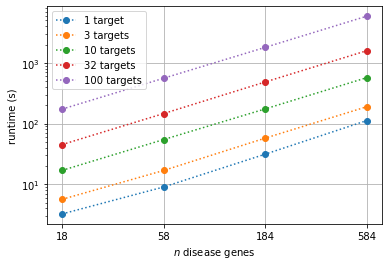

In [9]:
fig, ax = plt.subplots()
ngen = scaling.columns.to_list()
ngen.reverse()

for ntarg in scaling.index:
    label = '{} target'.format(ntarg) if ntarg == 1 else '{} targets'.format(ntarg)
    runt = scaling.loc[ntarg].to_list()
    runt.reverse()
    ax.plot(ngen, runt, label=label, linestyle='dotted', marker='o')
ax.set_yscale('log')
ax.set_xlabel(r'$n$ disease genes')
ax.set_ylabel('runtime (s)')
ax.grid()
ax.legend()

attila_utils.savefig(fig, 'runtime-n_disease_genes')

The following plot shows that runtime scales supralinearly with the number of targets.  However, the slope is quite shallow: for instance going from 1 target to 10 targets increases the runtime only about 5-7 fold.  Going from 10 targets to 100 targets increases the runtime about 10 fold.

['named-figure/runtime-n_targets.png', 'named-figure/runtime-n_targets.pdf']

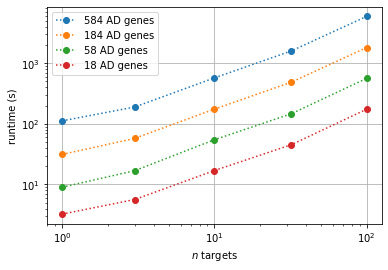

In [10]:
fig, ax = plt.subplots()
for ngenes in scaling.columns:
    label = '{} AD genes'.format(ngenes)
    ax.plot(scaling.index, scaling[ngenes], label=label, linestyle='dotted', marker='o')
ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$n$ targets')
ax.set_ylabel('runtime (s)')
ax.grid()

attila_utils.savefig(fig, 'runtime-n_targets')

## Parallel efficiency

What follows is the analysis of the benefits and costs of running `proximity.py` with increasing CPUs on NIH's HPC server Biowulf.  Hyperthreading was enabled thus 1 core means 2 CPUs.  The benefit is, of course, a faster run of `proximity.py`.  The drawback is possibly longer waiting time in the queue managed by the job scheduling system, SLURM.

Test run conditions:
* input: knowledge based AD genes
* input: first 10% of drug-target interactions in the drug-target network
* [E5 2650 Xeon processors](https://ark.intel.com/content/www/us/en/ark/products/64590/intel-xeon-processor-e52650-20m-cache-2-00-ghz-8-00-gts-intel-qpi.html) see --constraint=x2650 #SBATCH directive in test-$n$cpu.cfg

In [11]:
ncpus = pd.read_csv('../../results/2021-11-18-proximity-run-benchmark/ncpus.csv')
ncpus = ncpus.loc[ncpus.Status == 'COMPLETED']
ncpus['log10 Runtime (min)'] = ncpus['Runtime (min)'].apply(np.log10)
ncpus['log2 CPUs'] = np.int64(ncpus.CPUs.apply(np.log2))
ncpus['Parallel efficiency'] = ncpus.apply(lambda row: ncpus.loc[ncpus.CPUs == 2, 'Runtime (min)'] * 2 / row['Runtime (min)'] / row['CPUs'], axis=1)

Thus we used the following definition (see [this page](https://researchcomputing.princeton.edu/support/knowledge-base/scaling-analysis)):
\begin{equation}
\text{parallel efficiency at } n \text{ CPUs} = \frac{\text{runtime at } 2 \text{ CPUs} * 2}{\text{runtime at } n \text{ CPUs} * n}
\end{equation}

['named-figure/runtime-parallel_efficiency-queue-n_cpus.png',
 'named-figure/runtime-parallel_efficiency-queue-n_cpus.pdf']

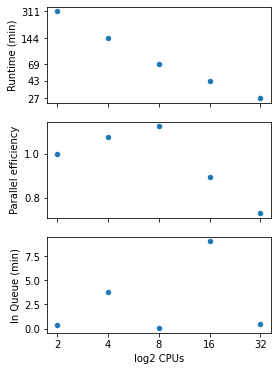

In [12]:
fig, ax = plt.subplots(3, 1, figsize=(4, 6), sharex=True)
ax[0] = ncpus.plot(kind='scatter', y='log10 Runtime (min)', x='log2 CPUs', ax=ax[0])
ax[0].set_yticks(ncpus['log10 Runtime (min)'])
ax[0].set_yticklabels(ncpus['Runtime (min)'].apply(np.round).apply(np.int64))
ax[0].set_ylabel('Runtime (min)')
ax[1] = ncpus.plot(kind='scatter', y='Parallel efficiency', x='log2 CPUs', ax=ax[1])
ax[2].set_xticks(ncpus['log2 CPUs'])
ax[2].set_xticklabels(ncpus['CPUs'].apply(np.int64))
ax[2].set_xlabel('n CPUs (x2650)')
ax[2] = ncpus.plot(kind='scatter', y='In Queue (min)', x='log2 CPUs', ax=ax[2])

attila_utils.savefig(fig, 'runtime-parallel_efficiency-queue-n_cpus')

## Estimated and measured runtime for a complete screen

We see that parallel efficiency is the highest at 8 CPUs.  Yet, the waiting times in the queue are short (albeit with a small drug target network that's only 10% of the complete one) so it might be a good practice just running at 16 CPUs instead of 8 to obtain results faster.

$\approx 10\%$ of the drug-target network is processed in 43 min at 16 CPUs so we *estimate* $10 \times 43 \text{ min} = 7.2 \text{ h}$ for $100\%$ of the drug-target network.  However, the `jobhist` command output shows that the *measured* runtime is only 05:38:26 $\approx 5.6 \text{ h}$



In [13]:
%%bash
cat ../../results/2021-11-18-proximity-run-benchmark/knowledge-16cpu.jobhist


JobId              : 27239098
User               : jonesa7
Submitted          : 20211122 15:58:05
Started            : 20211122 16:01:49
Ended              : 20211122 21:40:15
Submission Path    : /data/jonesa7/results/2021-11-18-proximity-run-benchmark
Submission Command : sbatch --cpus-per-task=16 --time=10:00:00 knowledge-16cpu.sh

Jobid        Partition       State  Nodes  CPUs      Walltime       Runtime         MemReq  MemUsed  Nodelist
27239098          norm   COMPLETED      1    16      10:00:00      05:38:26      2.0GB/cpu    2.0GB  cn0023



## Best practices of running `proximity.py` on Biowulf

Use the following settings

* 16 CPUs: ` --cpus-per-task=16`
* E5 2650 Xeon processors: `--constraint=x2650`
* walltime with +25% safety margin: as a function of $n$ AD genes, see table below

In [14]:
refrunt = 5 + 36 / 60 + 26 / 3600 # in hours
ngenes = np.int64(np.round(np.logspace(np.log10(24), np.log10(1000), 30)))
walltimes = pd.DataFrame({'Runtime estimate (h)': [n / 24 * refrunt for n in ngenes]}, index=ngenes)
walltimes.index = walltimes.index.set_names('n AD genes')
walltimes['Runtime estimate'] = walltimes['Runtime estimate (h)'].apply(lambda h: datetime.timedelta(minutes=np.round(h * 60)))
walltimes['+25% walltime'] = walltimes['Runtime estimate (h)'].apply(lambda h: datetime.timedelta(minutes=np.round(h * 60 * 1.25)))
walltimes

,Runtime estimate (h),Runtime estimate,+25% walltime
n AD genes,,,
24,5.607222,0 days 05:36:00,0 days 07:01:00
27,6.308125,0 days 06:18:00,0 days 07:53:00
31,7.242662,0 days 07:15:00,0 days 09:03:00
35,8.177199,0 days 08:11:00,0 days 10:13:00
40,9.345370,0 days 09:21:00,0 days 11:41:00
46,10.747176,0 days 10:45:00,0 days 13:26:00
52,12.148981,0 days 12:09:00,0 days 15:11:00
59,13.784421,0 days 13:47:00,0 days 17:14:00
67,15.653495,0 days 15:39:00,0 days 19:34:00


In [15]:
%connect_info

{
  "shell_port": 56897,
  "iopub_port": 56898,
  "stdin_port": 56899,
  "control_port": 56901,
  "hb_port": 56900,
  "ip": "127.0.0.1",
  "key": "f1bdd111-9e963beae301bbc798bfd30c",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-e723b8fb-8ad9-4b3c-a08f-ec7b8e44c998.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
